# Setup

In [36]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt

class Gas:
    def __init__(self, R, gamma):
        self.R = R
        self.gamma = gamma
    def __repr__(self):
        return (f'Gas(R={self.R}), gamma={self.gamma}')
    
class Liquid:
    def __init__(self, density):
        self.density = density
    def __repr__(self):
        return (f'Liquid(density={self.density})')
    

import numpy as np

def gasFlowrate(Kv, P_1, P_2, T_1, gas, assumeChoked=False):
    """
    Calculates gas mass flow rate using the Simplified Kv Model (Tameson).
    Includes broadcasting to handle mix of scalar and array inputs.
    """
    # --- 1. Unit Conversion & Constants ---
    # Convert inputs to standard numpy arrays of float type
    P_1 = np.atleast_1d(P_1).astype(float)
    P_2 = np.atleast_1d(P_2).astype(float)
    T_1 = np.atleast_1d(T_1).astype(float)
    Kv  = np.atleast_1d(Kv).astype(float)
    
    # --- BROADCASTING FIX ---
    # This ensures that if Kv is [1] and P_1 is length 5, Kv becomes length 5
    try:
        P_1, P_2, T_1, Kv = np.broadcast_arrays(P_1, P_2, T_1, Kv)
    except ValueError:
        raise ValueError("Input shapes (P, T, Kv) are incompatible and cannot be broadcast together.")

    # Constants for Standard Conditions (NTP: 0°C, 1 atm)
    P_N_Pa = 101325.0       # Pa
    T_N_K  = 273.15         # K
    rho_n  = P_N_Pa / (gas.R * T_N_K) # Normal Density (kg/m^3)

    # Convert Pressures to BAR for the Kv formula
    p1_bar = P_1 / 1e5
    p2_bar = P_2 / 1e5

    # --- 2. Flow Direction Logic ---
    # Identify reverse flow (P2 > P1) and swap variables for calculation
    reverse_mask = p2_bar > p1_bar
    
    pu = np.where(reverse_mask, p2_bar, p1_bar) # Upstream Pressure (bar)
    pd = np.where(reverse_mask, p1_bar, p2_bar) # Downstream Pressure (bar)

    # --- 3. Choked Flow Determination ---
    # Simplified Model assumes choking at P_down < P_up / 2
    critical_ratio = 0.5
    
    # Handle assumeChoked (scalar or array)
    assumeChoked = np.atleast_1d(assumeChoked)
    # Broadcast assumeChoked to shape of P_1 if necessary, or let numpy broadcasting handle the 'or' logic
    
    # Determine if flow is choked (physically choked OR forced by user)
    # Note: We use bitwise OR (|) for boolean arrays
    is_choked = (pd < (pu * critical_ratio)) | ((assumeChoked == True) | (assumeChoked == 1))

    # --- 4. Flow Rate Calculation (Q_n in Nm^3/h) ---
    q_n = np.zeros_like(pu)

    # A. Subcritical Flow (P_down > P_up / 2)
    sub_idx = ~is_choked
    if np.any(sub_idx):
        dp_sub = pu[sub_idx] - pd[sub_idx]
        # Protect against negative sqrt near zero
        term = np.maximum(dp_sub * pd[sub_idx], 0) 
        
        q_n[sub_idx] = 514 * Kv[sub_idx] * np.sqrt(
            term / (rho_n * T_1[sub_idx])
        )

    # B. Supercritical / Choked Flow (P_down < P_up / 2)
    choked_idx = is_choked
    if np.any(choked_idx):
        q_n[choked_idx] = 257 * Kv[choked_idx] * pu[choked_idx] * np.sqrt(
            1.0 / (rho_n * T_1[choked_idx])
        )

    # --- 5. Final Conversion to Mass Flow (kg/s) ---
    m_dot = q_n * rho_n / 3600.0

    # Apply sign for reverse flow
    m_dot = np.where(reverse_mask, -m_dot, m_dot)

    return m_dot

import numpy as np

def liquidFlowrate(Kv, P_1, P_2, liquid):
    """
    Calculates liquid mass flow rate (kg/s) using Kv.
    
    Parameters:
        Kv  : Flow coefficient (m^3/h water @ 1 bar dP)
        P_1 : Upstream pressure (Pa)
        P_2 : Downstream pressure (Pa)
        liquid : Object with .density attribute (kg/m^3)
        
    Returns:
        m_dot : Mass flow rate (kg/s). Negative value indicates reverse flow.
    """
    # --- 1. Broadcast Inputs ---
    # Ensure inputs match shapes (handles scalar Kv with array Pressure)
    P_1 = np.atleast_1d(P_1).astype(float)
    P_2 = np.atleast_1d(P_2).astype(float)
    Kv  = np.atleast_1d(Kv).astype(float)
    
    try:
        P_1, P_2, Kv = np.broadcast_arrays(P_1, P_2, Kv)
    except ValueError:
        raise ValueError("Input shapes are incompatible.")

    # --- 2. Calculate Pressure Drop ---
    dp = P_1 - P_2
    
    # --- 3. Calculate Mass Flow ---
    # Formula: m_dot = (Kv / 36000) * sqrt(rho * abs(dp))
    # We use np.sign(dp) to handle reverse flow direction automatically
    
    # Constant derived from: 0.1 (unit conversions) / 3600 (hours to seconds)
    CONST_LIQUID = 1 / 36000.0
    
    m_dot = (np.sign(dp) * CONST_LIQUID * Kv * np.sqrt(np.abs(dp) * liquid.density))

    return m_dot


import numpy as np

import numpy as np

def valve_timing(t, maxKv, t_open, t_close, t_ramp, leak=1e-8):
    """
    Single function for a full valve cycle using Smooth Sigmoids (S-Curves).
    Best for ODE solvers (scipy.solve_ivp) as it has continuous derivatives.
    
    Parameters:
        t       : Current time (scalar or array)
        maxKv   : Maximum Kv
        t_open  : Start time for OPENING
        t_close : Start time for CLOSING
        t_ramp  : Time duration for the transition (approximate)
        leak    : Minimum Kv value (to prevent solver singularities)
    """
    # 1. Standardize input
    is_scalar = np.isscalar(t) or np.ndim(t) == 0
    t = np.atleast_1d(t).astype(float)
    
    # 2. Calculate Steepness (k)
    # A 'k' factor of 12/t_ramp ensures the curve completes ~99% of its 
    # transition within the t_ramp window.
    k = 12.0 / t_ramp
    
    # 3. Calculate Centers
    # We center the S-curve at the midpoint of the ramp
    center_open = t_open + (t_ramp / 2.0)
    center_close = t_close + (t_ramp / 2.0)
    
    # 4. Generate Curves (0.0 to 1.0)
    # Opening: standard sigmoid (low -> high)
    # Equation: 1 / (1 + e^-k(t - center))
    sig_open = 1.0 / (1.0 + np.exp(-k * (t - center_open)))
    
    # Closing: inverted sigmoid (high -> low)
    # Equation: 1 - sigmoid
    sig_close = 1.0 - (1.0 / (1.0 + np.exp(-k * (t - center_close))))
    
    # 5. Combine
    # We multiply them. If either is 0 (closed), the result is 0.
    # This naturally creates a smooth bell-shape if the valve closes 
    # before it finishes opening.
    Kv = maxKv * sig_open * sig_close
    
    # 6. Apply Leak (Clip)
    Kv = np.maximum(Kv, leak)
    
    if is_scalar:
        return Kv.item()
    return Kv


# Tests

In [19]:
N2 = Gas(R= 296.8, gamma = 1.4)
print(gasFlowrate(1, [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], 300 * np.ones(5), N2, True))
print(gasFlowrate(1, [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], 300 * np.ones(5), N2))
print(gasFlowrate([1], [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], 300 * np.ones(5), N2))
print(gasFlowrate(1, 2e5, 1e5, 300, N2))
print(gasFlowrate([1], 2e5, 1e5, 300, N2))

[ 0.00921565  0.00691173  0.00460782 -0.00691173 -0.00921565]
[ 0.00921565  0.00651645  0.         -0.00651645 -0.00921565]
[ 0.00921565  0.00651645  0.         -0.00651645 -0.00921565]
[0.00921565]
[0.00921565]


In [20]:
IPA = Liquid(density = 800)
print(liquidFlowrate(1, [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], IPA))


[ 0.248452    0.17568209  0.         -0.17568209 -0.248452  ]


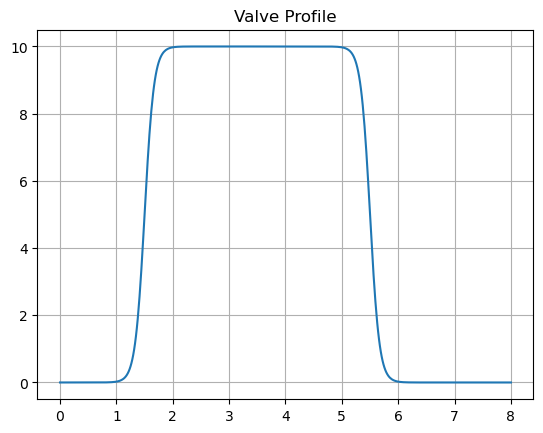

In [39]:
import matplotlib.pyplot as plt

t_vals = np.linspace(0, 8, 500)
# Open at 1s, Close at 5s, Ramp takes 1s
kv_vals = valve_timing(t_vals, maxKv=10, t_open=1, t_close=5, t_ramp=1)

plt.plot(t_vals, kv_vals)
plt.title("Valve Profile")
plt.grid(True)
plt.show()

# DAE System

In [58]:
N2 = Gas(R= 296.8, gamma = 1.4)
O2 = Gas(R= 259.8, gamma = 1.4)
IPA = Liquid(density = 800)

V_1 = 3 * 0.001 #3L HP Tank
V_2 = 10 * 0.001 #10L LP Tank (Thomas)

#Starting densities
T_0 = 273.15 + 10

rho_1_0 = 300e5 / (N2.R * T_0) #rho = P / RT
rho_2_0 = 35e5 / (N2.R * T_0) #rho = P / RT

def dae_system(t, z):
    m_1, m_2, m_3 = z

    # m_1 is nitrogen tank
    # m_2 is amount of nitrogen in IPA tank
    # m_3 is amount of IPA in IPA tank

    # Explicit Algebraic Equations
    rho_1 = m_1 / V_1
    rho_2 = m_2 / (V_2-m_3/IPA.density)

    T_1 = T_0 * (rho_1_0 / rho_1) ** (1 - N2.gamma)
    T_2 = T_0 * (rho_2_0 / rho_2) ** (1 - N2.gamma)

    P_1 = rho_1 * N2.R * T_1
    P_2 = rho_2 * N2.R * T_2

    reg_pressure = 35e5
    reg_dp = reg_pressure - P_2
    reg_kv = np.where(reg_dp > 0, reg_dp / 300 / 1e5, 0.0)



    mdot_1 = - gasFlowrate(reg_kv, P_1, P_2, 300, N2)
    mdot_2 = - mdot_1
    mdot_3 = - liquidFlowrate(valve_timing(t, maxKv=0.2, t_open=0.5, t_close=4.5, t_ramp=0.5), P_2, 1e5, IPA)

    return mdot_1, mdot_2, mdot_3

m_3 = 8 * 0.001 * IPA.density #8L IPA
m_1_0 = V_1 * rho_1_0
m_2_0 = (V_2 - m_3/IPA.density) * rho_2_0 

z0 = [m_1_0, m_2_0, m_3]
t_span = (0, 10)
t_eval = np.linspace(*t_span, 200)
# # Solve the system
solution = solve_ivp(dae_system, t_span, z0, t_eval=t_eval, method="LSODA")


C:\Users\Martin\AppData\Local\Temp\ipykernel_22140\3376970604.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axb2.legend(loc='center right')


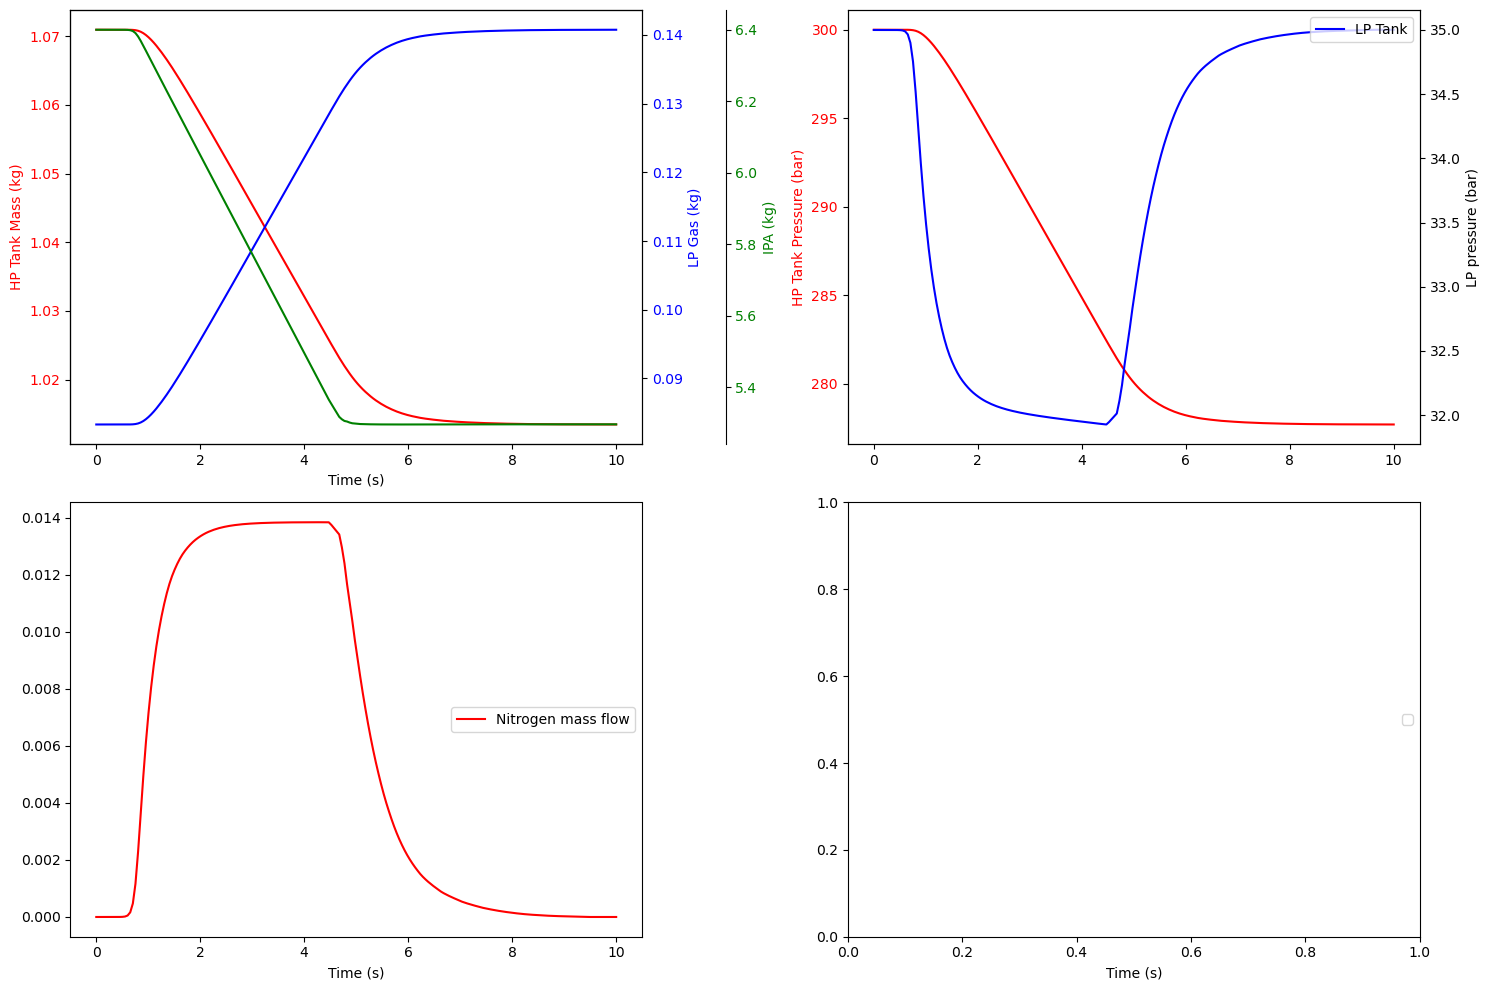

In [60]:
t = solution.t
m_1, m_2, m_3 = solution.y
rho_1 = m_1 / V_1
rho_2 = rho_2 = m_2 / (V_2-m_3/IPA.density)
T_1 = T_0 * (rho_1_0 / rho_1) ** (1 - N2.gamma)
T_2 = T_0 * (rho_2_0 / rho_2) ** (1 - N2.gamma)

P_1 = rho_1 * N2.R * T_1
P_2 = rho_2 * N2.R * T_2

# # Plot the results
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax1 = ax[0,0]
ax1.plot(t, m_1, label="HP Tank", color='red')
ax1.set_ylabel('HP Tank Mass (kg)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('Time (s)')

ax2 = ax1.twinx()
ax2.plot(t, m_2, label="LP Gas", color='blue')
ax2.set_ylabel('LP Gas (kg)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
ax3.plot(t, m_3, label="IPA", color='green')
ax3.tick_params(axis='y', labelcolor='g')
ax3.set_ylabel('IPA (kg)', color='g')
ax3.spines['right'].set_position(('outward', 60))

ax4 = ax[0,1]
#ax4.plot(solution.t, P_1 / 1e5, label="HP Tank", color='red')
#ax5 = ax4.twinx()


ax4.plot(solution.t, P_1 / 1e5, label="HP Gas", color='red')
ax5 = ax4.twinx()
ax4.set_ylabel('HP Tank Pressure (bar)', color='r')
ax4.tick_params(axis='y', labelcolor='r')
ax5.plot(solution.t, P_2 / 1e5, label="LP Tank", color='blue')
# ax5.plot(solution.t, P_MechRegCheckValveIntermediete / 1e5, label="Post Reg", color='green')
ax5.set_ylabel('LP pressure (bar)', color='black')
ax5.tick_params(axis='y', labelcolor='black')
ax5.legend(loc='upper right')
#ax5.plot(solution.t, Kv_Mechreg(35e5 , P_2) * 0.01, label="LP Gas", color='green')
#ax4.plot(solution.t, rho_2, label="LP Gas", color='blue')


#ax6 = ax5.twinx()
#ax6.plot(solution.t, solution.y[2], label="IPA", color='green')
#ax6.spines['right'].set_position(('outward', 60))

axb1 = ax[1,0]
# axb1.plot(t,abs(mdot_1), label = "Nitrogen mass flow", color='red')
axb1.plot(t, gasFlowrate(np.where(P_2 < 35e5, (35e5 - P_2) / 300 / 1e5, 0), P_1, P_2, T_1, N2), label = "Nitrogen mass flow", color='red')
# flow1 = singleGasFlowrate(np.atleast_1d(np.where(P_MechRegCheckValveIntermediete < 35e5, (35e5-P_MechRegCheckValveIntermediete) / 300 / 1e5, 0)), P_1, P_MechRegCheckValveIntermediete, T_1, N2, False)
# flow2 = singleGasFlowrate(valve_timing(t, 0.05, 3, 6, 0.5), P_MechRegCheckValveIntermediete, P_2, T_1, N2, [False, False])
#flow3 = singleGasFlowrate(0.05, P_MechRegCheckValveIntermediete2, P_2, T_1, N2, [True, True])
# axb1.plot(t, flow1, label = "Nitrogen mass flow", color='red')
# axb1.plot(t, flow2, label = "Nitrogen mass flow", color='blue')
#axb1.plot(t, flow3, label = "Nitrogen\mass flow", color='green')
axb1.legend(loc='center right')
axb1.set_xlabel('Time (s)')
#axb1.set_ylabel('Nitrogen mass flow (kg/s)', color='r')

axb2 = ax[1,1]
# axb2.plot(t,valve_timing(t, 0.2, 1, 9, 0.5), label = "IPA Valve Kv", color='red')
# axb2.plot(t,valve_timing(t, 0.05, 3, 6, 0.5), label = "Pressurization Valve Kv", color='green')
axb2.set_xlabel('Time (s)')
#axb2.set_ylabel('Fuel mass flow (kg/s)', color='b')
axb2.legend(loc='center right')

fig.tight_layout()

In [55]:
initial_n2_mass = m_1_0 + m_2_0
print(f"Initial N2 Mass: {initial_n2_mass:.4f} kg")

Initial N2 Mass: 1.1542 kg
